In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os

In [2]:
folder_path = 'data'
datasets = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

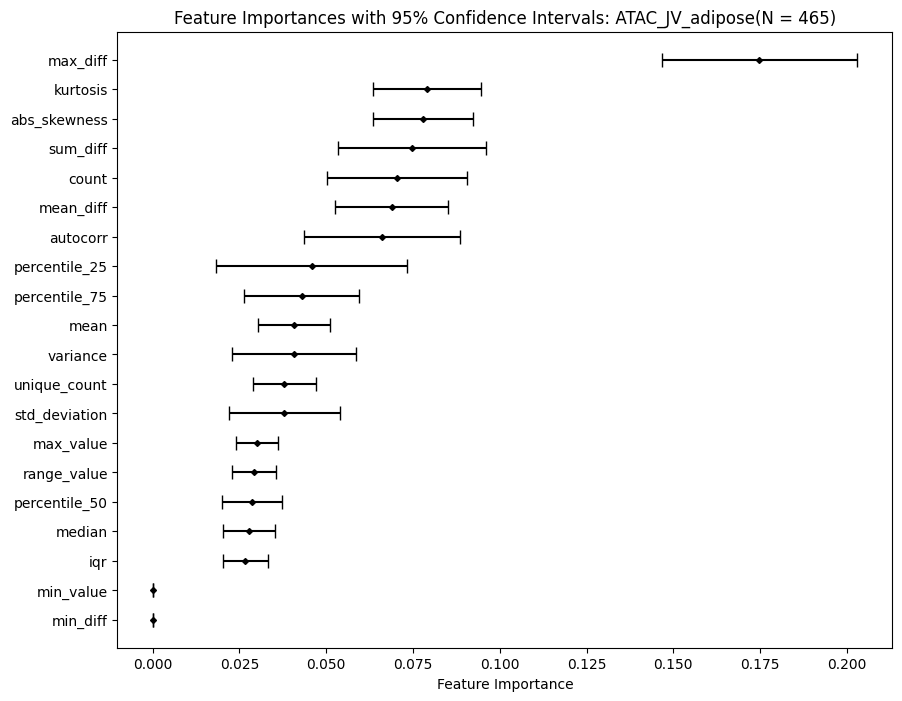

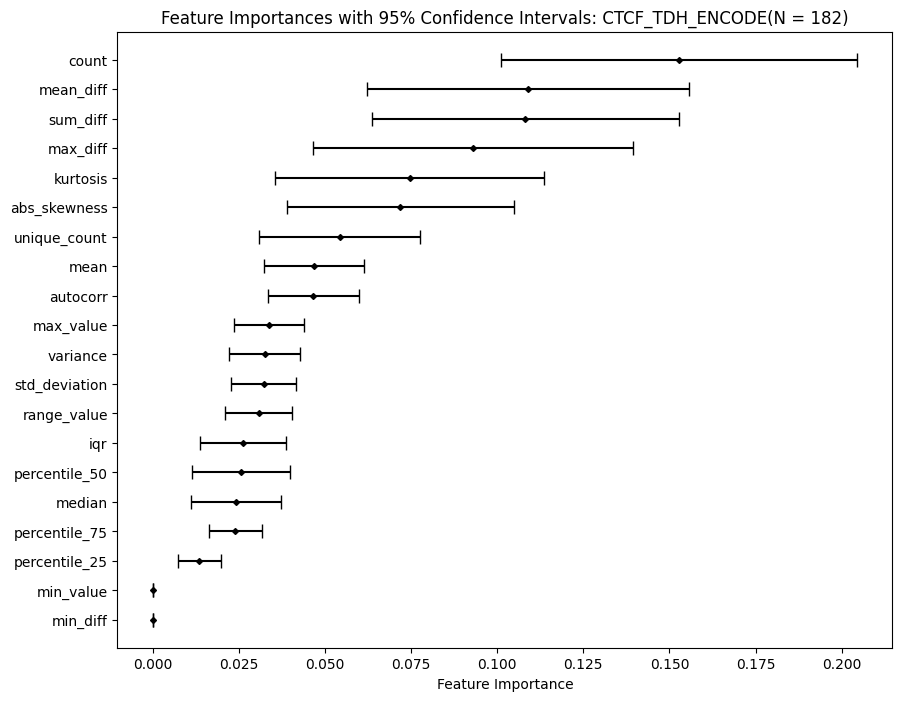

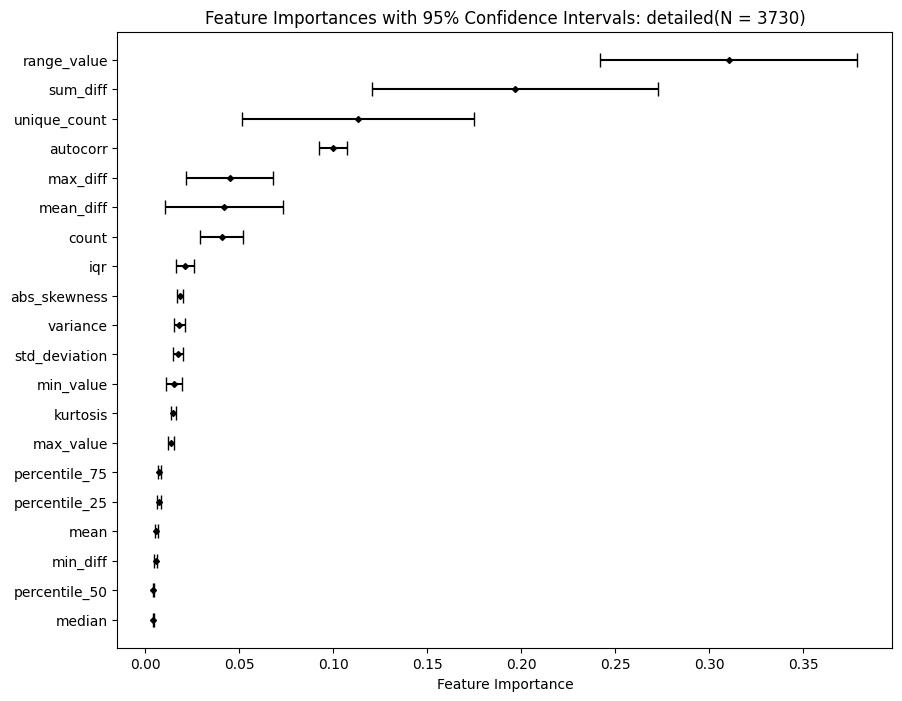

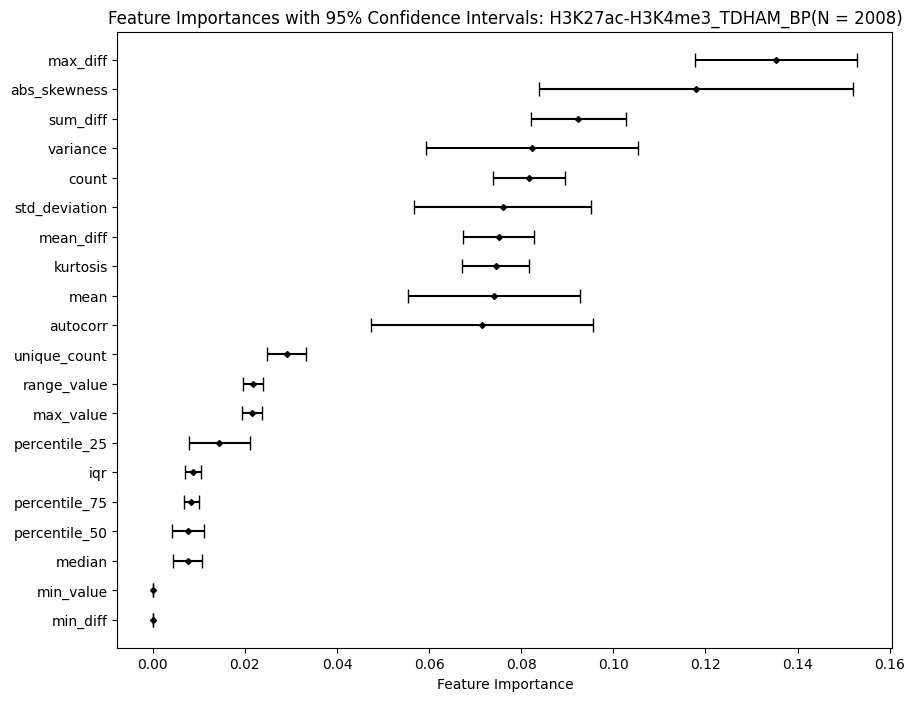

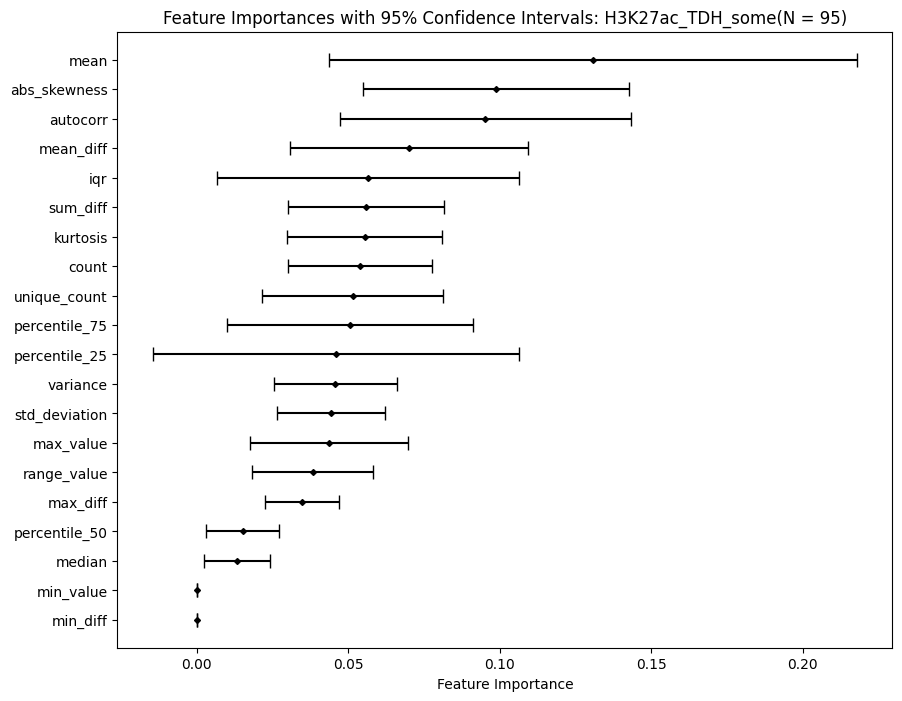

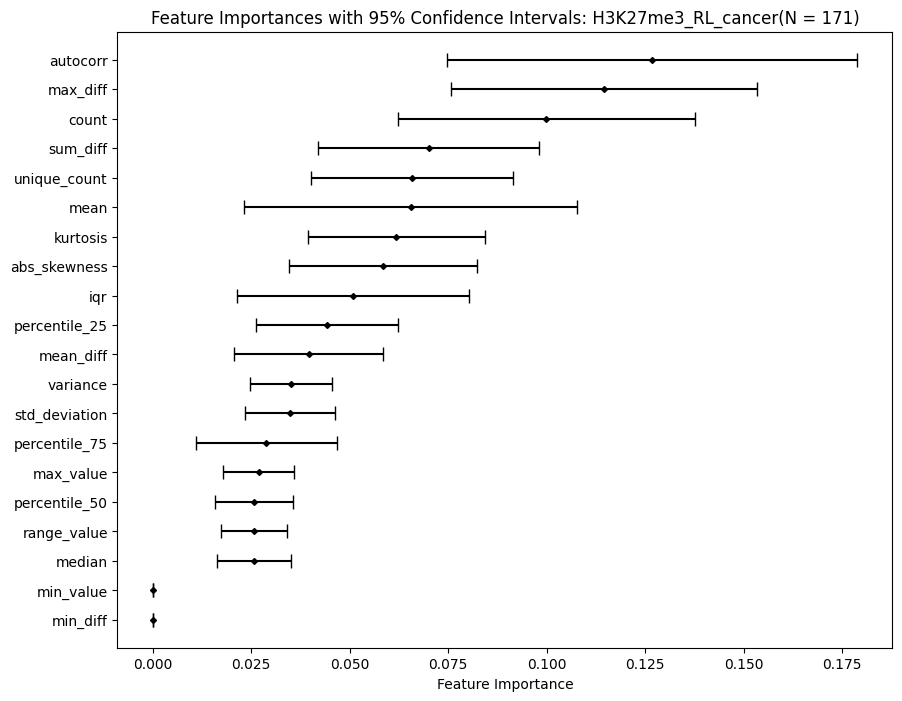

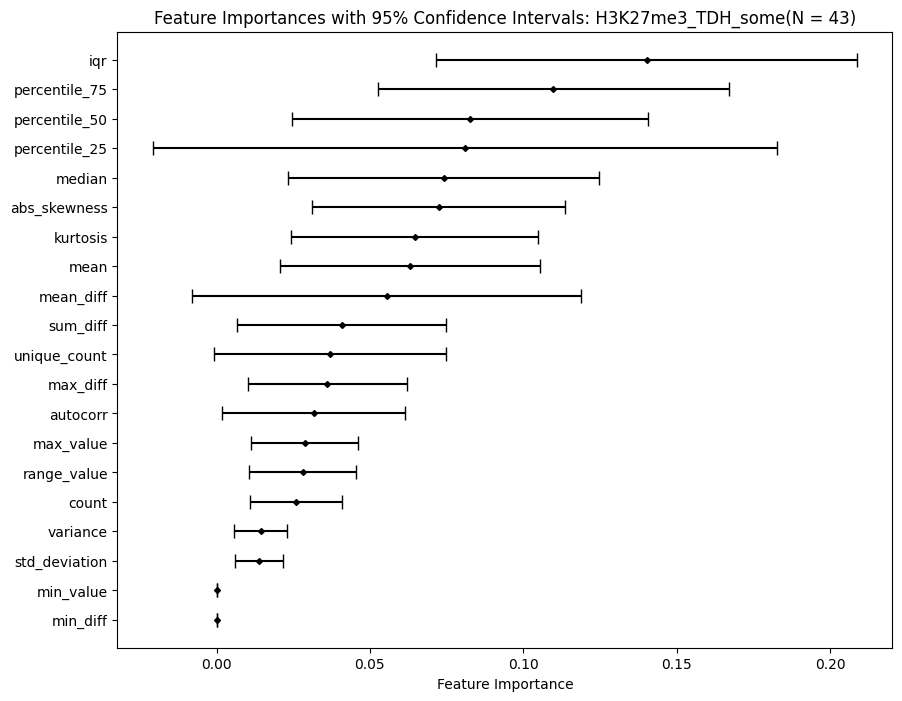

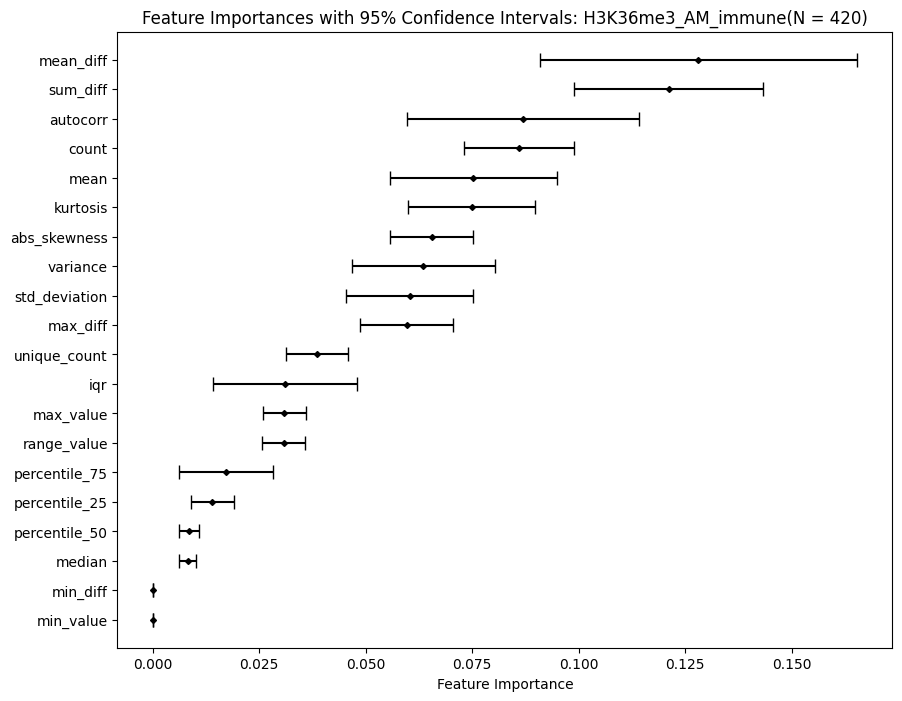

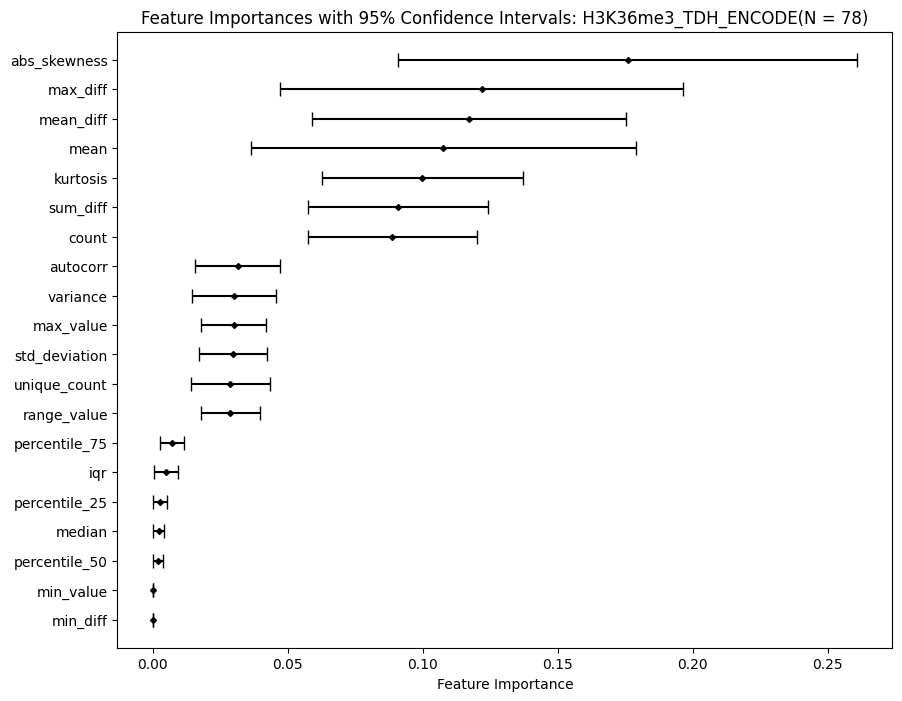

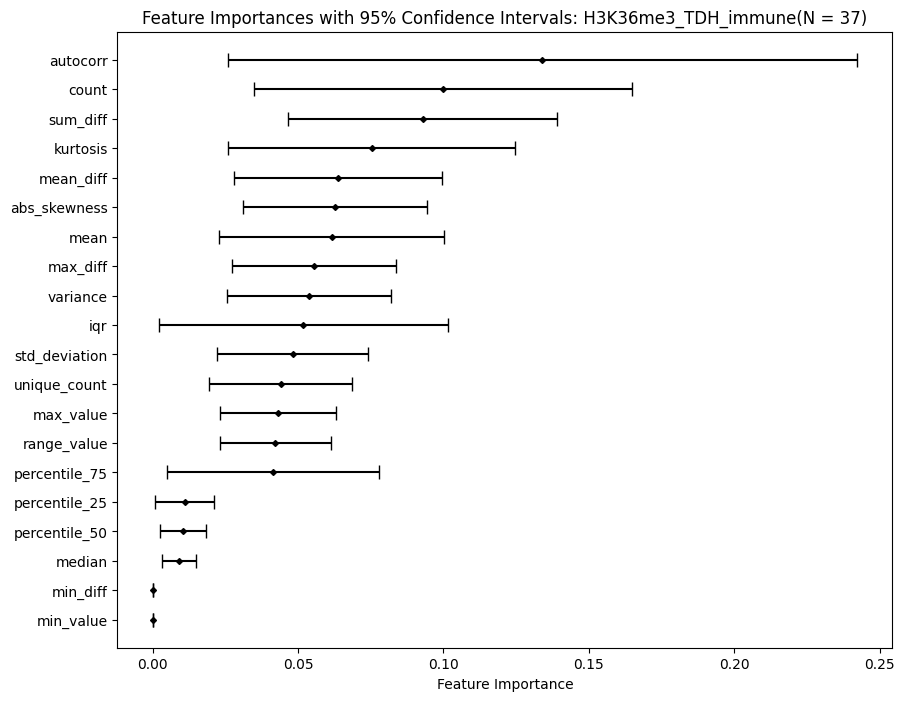

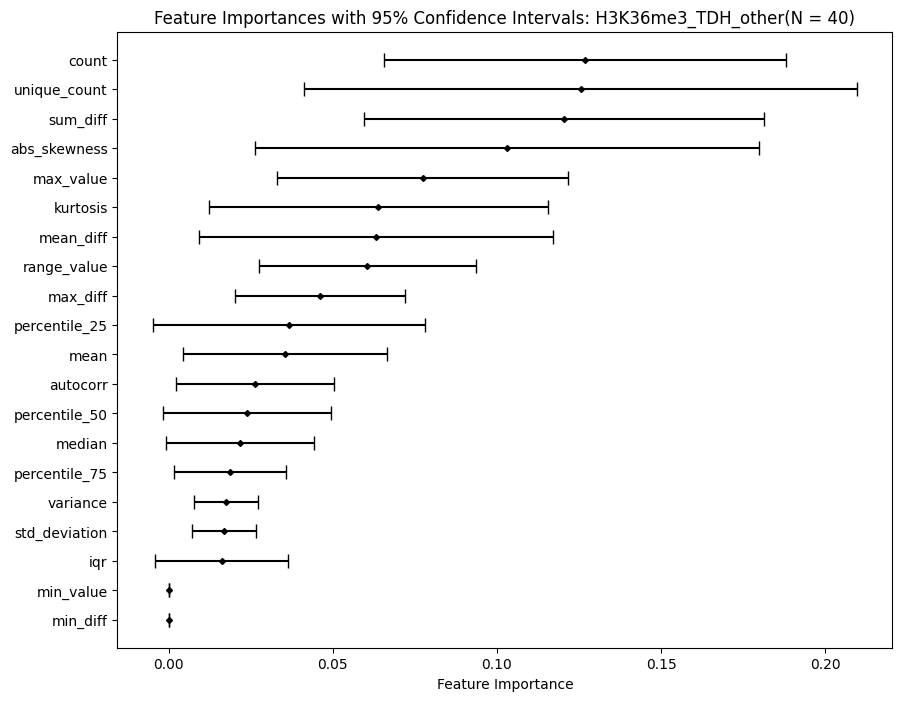

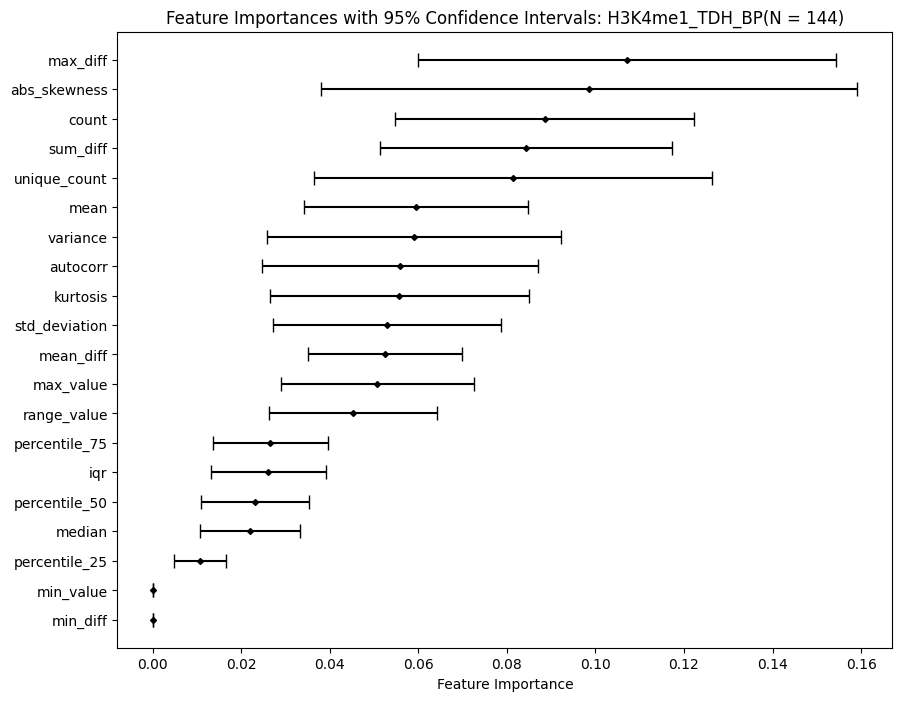

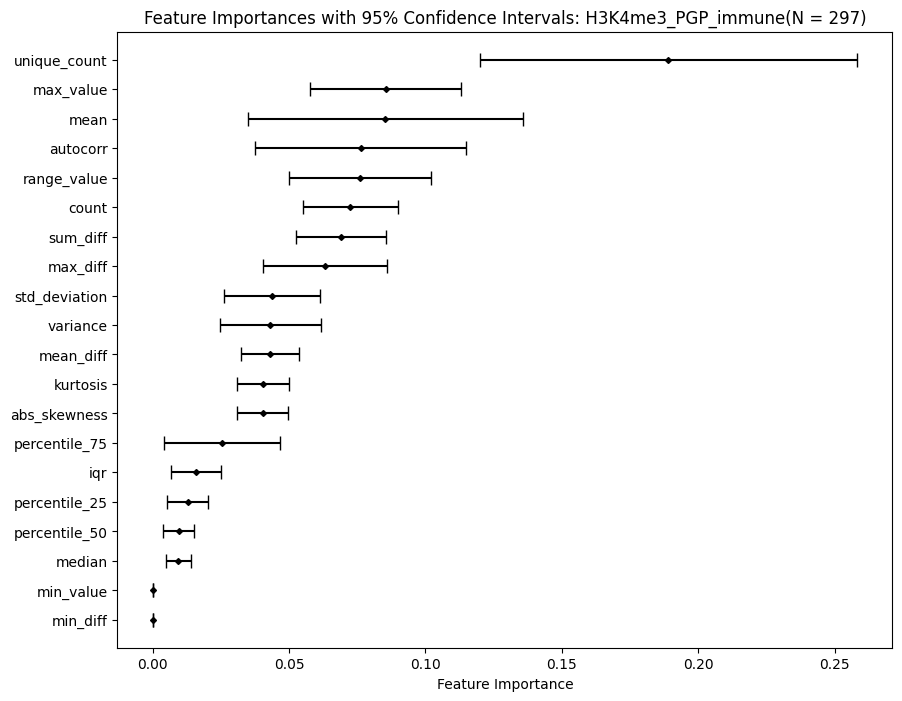

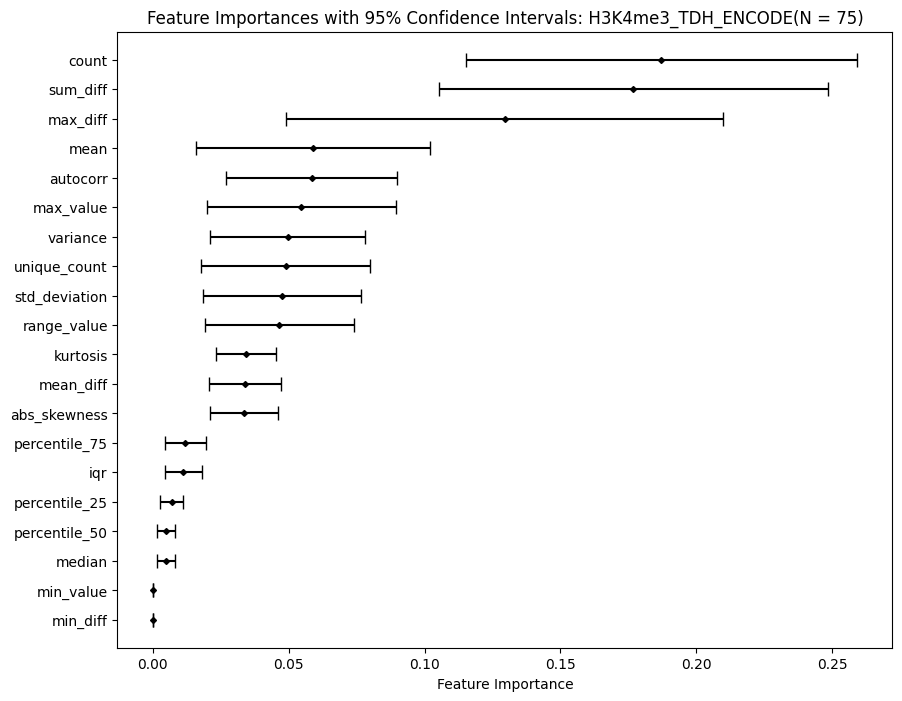

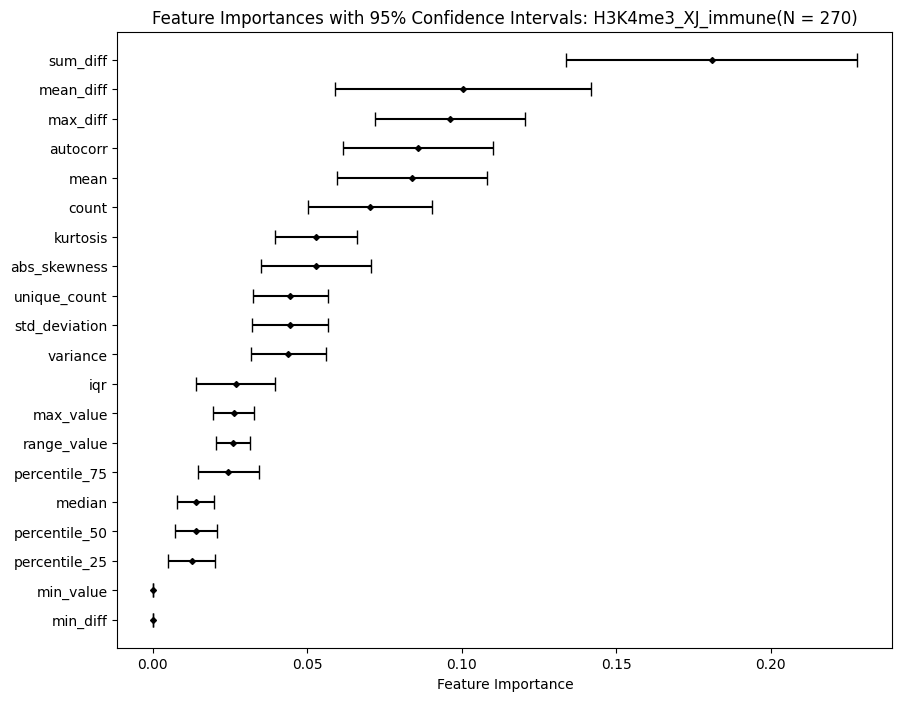

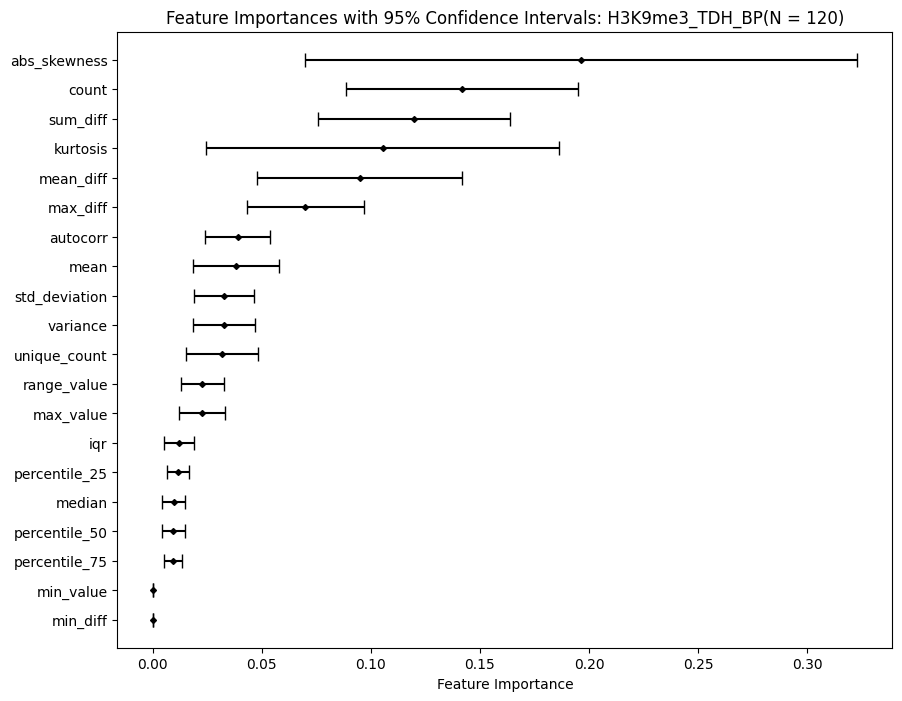

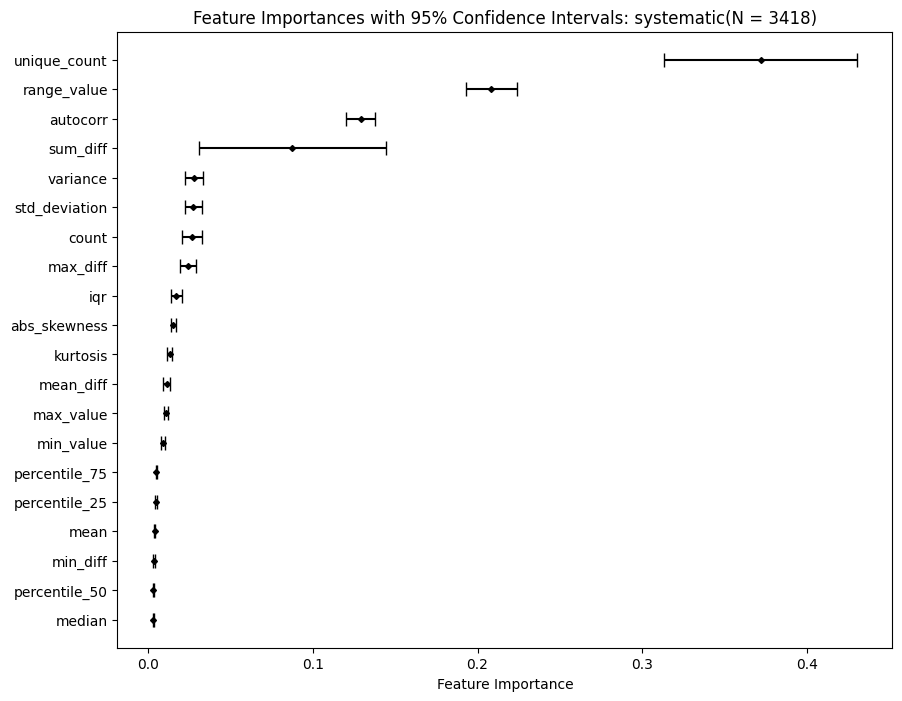

In [3]:
# Load the dataset
for dataset in datasets:
    feature_df = pd.read_csv('data/' + dataset + '/features.csv')
    target_df = pd.read_csv('data/' + dataset + '/target.csv')
    
    # Drop the specified columns from target_df
    target_df_filtered = target_df.drop(columns=['sequenceID', 'max.log.lambda'])

    # Concatenate feature_df and the filtered target_df
    feature_target_df = pd.concat([feature_df, target_df_filtered], axis=1)

    # Replace -inf with NaN
    feature_target_df['min.log.lambda'].replace(-np.inf, np.nan, inplace=True)

    # Drop rows with NaN values in column 'min.log.lambda'
    feature_target_df = feature_target_df.dropna(subset=['min.log.lambda'])

    # Replace '#NAME?' with NaN
    feature_target_df.replace('#NAME?', 0, inplace=True)

    X = feature_target_df[list(feature_target_df.columns)[1:21]]
    y = feature_target_df['min.log.lambda']

    # Create a Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Number of bootstrap samples
    n_bootstraps = 100

    # Initialize an array to store the importances for each bootstrap
    importances = np.zeros((n_bootstraps, X.shape[1]))

    # Bootstrapping
    for i in range(n_bootstraps):
        X_resampled, y_resampled = resample(X, y)    # Create a bootstrap sample
        rf.fit(X_resampled, y_resampled)             # Fit the model on the bootstrap sample
        importances[i, :] = rf.feature_importances_  # Store the feature importances

    # Calculate the mean importance and the confidence intervals
    mean_importances = np.mean(importances, axis=0)
    std_importances = np.std(importances, axis=0)
    lower_bound = mean_importances - std_importances
    upper_bound = mean_importances + std_importances

    # Sort the indices based on mean_importances
    sorted_indices = np.argsort(mean_importances)

    # Sort the data accordingly
    sorted_mean_importances = mean_importances[sorted_indices]
    sorted_lower_bound = lower_bound[sorted_indices]
    sorted_upper_bound = upper_bound[sorted_indices]
    sorted_features = X.columns[sorted_indices]

    plt.figure(figsize=(10, 8))
    plt.errorbar(sorted_mean_importances, sorted_features, 
                xerr=[sorted_mean_importances - sorted_lower_bound, 
                    sorted_upper_bound - sorted_mean_importances], 
                fmt='D', color='black', ecolor='black', capsize=5, markersize=3)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances with 95% Confidence Intervals' + ": " + dataset + "(N = " + str(target_df.shape[0]) + ")")

    plt.savefig("figs/random_forest_" + dataset + ".png")
    plt.show()

In [4]:
# # Print the feature importances with confidence intervals
# print("Feature Importances with Confidence Intervals:")
# for i, feature in enumerate(X.columns):
#     print(f"Feature {feature:15}: Mean = {mean_importances[i]:.4f}, 95% CI = [{lower_bound[i]:.4f}, {upper_bound[i]:.4f}]")